In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from scipy.stats.stats import pearsonr   
import scipy.stats as ss
import scipy.signal as ssg
from scipy.io import savemat
import time
import h5py
import mne
import timeit
import random
import glob  
import re

def spatial_cov(data):
    #input[ch time nstimuli]
    return(np.cov(data.reshape([data.shape[0],-1])))

def spatial_corr(data):
    #input[ch time nstimuli]
    return(np.corrcoef(data.reshape([data.shape[0],-1])))


def temporal_cov(data):
    #input[ch time nstimuli]
    data=np.swapaxes(data,1,0)
    return(np.cov(data.reshape([data.shape[0],-1])))

def temporal_corr(data):
    #input[ch time nstimuli]
    data=np.swapaxes(data,1,0)
    return(np.corrcoef(data.reshape([data.shape[0],-1])))


def compress_dim_by_n_nosti(data,dim,n):
    #assume data is of [nch ntime ]
    
    data_output=np.zeros([int(data.shape[0]/n),data.shape[1]])
    for i in range(data_output.shape[0]):
        data_output[i]=np.mean(data[i*n:(i+1)*n],axis=0)
   
    return(data_output)


def compress_dim_by_n(data,dim,n):
    #assume data is of [ntime nch nstimuli]
    if dim==0:
        data_output=np.zeros([int(data.shape[0]/n),data.shape[1],data.shape[2]])
        for i in range(data_output.shape[0]):
            data_output[i]=np.mean(data[i*n:(i+1)*n],axis=0)
    elif dim ==1:
        data_output=np.zeros([data.shape[0],int(data.shape[1]/n),data.shape[2]])
        for i in range(data_output.shape[1]):
            data_output[:,i,:]=np.mean(data[:,i*n:(i+1)*n,:],axis=1)
    return(data_output)


def compare_features(features1, features2, metric='corr',individual = False):
    # compare features1 to features2 (order matters!)
    y_true = np.arange(len(features1))
    if metric=='corr':
        dists = np.corrcoef(features1.reshape(features1.shape[0],-1),features2.reshape(features2.shape[0],-1))[:len(features1),len(features1):]
    else:
        print('unrecognized metric!')
    y_pred=np.argmax(dists,axis=1)
    if individual:
        return(y_pred==y_true)
    else:
        return(np.mean(y_pred==y_true))


def get_acc_results(data, nrep=100,individual = False):
    # return [n_trainsizes, nsession^2, number of nrep]
    accs = []
    for kk in range(int(len(data[0][0])/nrep)): # train size loop
        accs_tmp=[]
        for i in range(len(data)):
            for j in range(len(data)):
                accs_tmp_tmp=[]                
                for k in range(nrep):
                    features1=data[i,:,k+kk*nrep]
                    features2=data[j,:,k+kk*nrep]
                    accs_tmp_tmp.append(compare_features(features1, features2,'corr',individual))
                accs_tmp.append(accs_tmp_tmp) 
        accs.append(accs_tmp)
    return(np.array(accs))


# FST (Figure 4)

In [ ]:
n_train_rep=100
features1=[]
features2=[]
features3=[]
root_dir = "path_to_root";
subj_names = ['AT','DR','JG','JK']

#[nsessions nsubjects ntrainsizes nrep_per_trainsize]
for session in [1,2,3,4]:
    tmp1 = []
    tmp2 = []
    tmp3 = []

    for subj in subj_names:
        names = glob.glob(root_dir+subj+'/session'+str(session)+'/fst_b*.fif')
        fname=names[-1]     
        data = sio.loadmat(fname[:-6]+'feature_sst_empty_filter_ecg_eog.mat')
        feature1 = data['feature1']
        feature2 = data['feature2']
        feature3 = data['feature3']
        tmp1.append(feature1)
        tmp2.append(feature2)
        tmp3.append(feature3)

    features1.append(tmp1)
    features2.append(tmp2)
    features3.append(tmp3)

feature1=np.array(features1)
feature2=np.array(features2)
feature3=np.array(features3dd)
features = [feature1,feature2,feature3]



accs=[get_acc_results(features[i], n_train_rep,True) for i in range(3)]  
accs=np.array(accs)

accs_rank=[get_acc_results(features[i][:,:, -n_train_rep:None],n_train_rep,False) for i in range(3)]  
accs_rank=np.array(accs_rank)




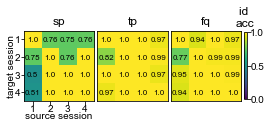

In [10]:
fig,axs = plt.subplots(1,3,figsize=(4,2))
colors=['b','orange','g']
titles=['sp','tp','fq']

for kk in range(3):
    data_to_plot= accs[kk,0,:].mean(axis=(-2,-1)).reshape([int(np.sqrt(accs.shape[2])),-1])
    im=axs[kk].imshow(data_to_plot, vmin=0,vmax=1)
    if kk==0:
        axs[kk].set_xticks(np.arange(int(np.sqrt(accs.shape[2]))))
        axs[kk].set_xticklabels(np.arange(int(np.sqrt(accs.shape[2])))+1)
        axs[kk].set_yticks(np.arange(int(np.sqrt(accs.shape[2]))))
        axs[kk].set_yticklabels(np.arange(int(np.sqrt(accs.shape[2])))+1)
        axs[kk].set_ylabel('target session',labelpad=-1.5)#changed!!!!!
        axs[kk].set_xlabel('source session',labelpad=-1.5)
    else:
        axs[kk].tick_params(
            axis='y',          
            which='both',     
            bottom=False,     
            left=False,        
            labelleft=False) 
        axs[kk].tick_params(
                    axis='x',         
                    which='both',     
                    bottom=False,     
                    left=False,         
                    labelbottom=False) 
    axs[kk].tick_params(axis='both', which='major', pad=-0.1)
    axs[kk].set_title(titles[kk])
    for i in range(int(np.sqrt(accs.shape[2]))):
        for j in range(int(np.sqrt(accs.shape[2]))):
            if data_to_plot[i, j]<=1/int(np.sqrt(accs.shape[2])):
                text = axs[kk].text(j, i, '{:.2}'.format(data_to_plot[i, j]) ,
                               ha="center", va="center", color="w",size=8)
            else:
                text = axs[kk].text(j, i, '{:.2}'.format(data_to_plot[i, j]) ,
               ha="center", va="center", color="k",size=8)

fig.subplots_adjust(wspace=0.05, hspace=0.35)
                
                

cbar = fig.colorbar(im,ax=axs,fraction=0.015, pad=0.01)
cbar.ax.set_title('id \nacc')
cbar.ax.tick_params(axis='both', which='major', pad=-0.1)



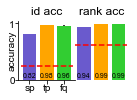

In [11]:
fig,axs = plt.subplots(1,2,figsize=(2,1.1))
colors=['slateblue','orange','limegreen']
titles=['id acc','rank acc']
acc_combined = [np.take(accs, [i for i in range(accs.shape[2]) if np.mod(i,int(np.sqrt(accs.shape[2]))+1)!=0], axis=2)
,np.take(accs_rank, [i for i in range(accs_rank.shape[2]) if np.mod(i,int(np.sqrt(accs_rank.shape[2]))+1)!=0], axis=2)
]


for kk in range(2):
    data_to_plot= acc_combined[kk][:,0]
    axs[kk].bar(np.arange(len(acc_combined[0])), data_to_plot.mean(axis=(-3,-2,-1)),yerr=[ss.sem(data_to_plot[i].reshape(-1)) for i in range(3)], capsize=0,color=colors)
    if kk==0:
        axs[kk].hlines(y=1/4, xmin=0-0.5, xmax=len(acc_combined[0])-1+0.5, linestyles='dashed', linewidth=1.5, label='random baseline', color='r')
        axs[kk].set_ylabel('accuracy',labelpad=-7)
    else: 
        axs[kk].hlines(y=(4+1)/(2*4), xmin=0-0.5, xmax=len(acc_combined[0])-1+0.5, linestyles='dashed', linewidth=1.5, label='random baseline', color='r')

    axs[kk].set_ylim([0,1.05])
    axs[kk].spines['right'].set_visible(False)
    axs[kk].spines['top'].set_visible(False)
    
    if kk>0:
        axs[kk].spines['bottom'].set_visible(False)
        axs[kk].spines['left'].set_visible(False)       
        axs[kk].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
        axs[kk].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off


    if kk==0:
        axs[kk].set_xticks(np.arange(3))
        axs[kk].set_xticklabels(['sp','tp','fq'])
    for jj in range(3):
        axs[kk].text(-0.4+jj, 0.05, '{:.2}'.format(data_to_plot.mean(axis=(-3,-2,-1))[jj]),size=7)
    axs[kk].tick_params(axis='both', which='major', pad=-0.1)
    axs[kk].set_title(titles[kk])
    
fig.subplots_adjust(wspace=-0.05)

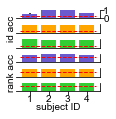

In [154]:
fig,axs = plt.subplots(6,1,figsize=(1.5,1.5))

colors=['slateblue','orange','limegreen']
titles=['sp','tp','fq']
acc_combined = [np.take(accs, [i for i in range(accs.shape[2]) if np.mod(i,int(np.sqrt(accs.shape[2]))+1)!=0], axis=2)
,np.take(accs_rank, [i for i in range(accs_rank.shape[2]) if np.mod(i,int(np.sqrt(accs_rank.shape[2]))+1)!=0], axis=2)
]
random_baselines = [1/4,(4+1)/(2*4)]

cnt = 0
for aid in range(2):
    for kk in range(3):
        data_to_plot= acc_combined[aid][kk,0]
        axs[cnt].bar(np.arange(acc_combined[aid][kk,0].shape[-1]), data_to_plot.mean(axis=(0,1)),yerr=[ss.sem(data_to_plot[:,:,i].reshape(-1)) for i in range(data_to_plot.shape[-1])], capsize=0,color=colors[kk])
        axs[cnt].hlines(y=random_baselines[aid], xmin=0-0.5, xmax=acc_combined[aid][kk,0].shape[-1]-1+0.5, linestyles='dashed', linewidth=1, label='random baseline', color='r')
        axs[cnt].set_ylim([0,1.05])
        axs[cnt].spines['left'].set_visible(False)
        axs[cnt].spines['top'].set_visible(False)
        axs[cnt].yaxis.tick_right()
        if cnt<5:
            axs[cnt].tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
        if cnt>0:
            axs[cnt].tick_params(
                    axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    right=False,      # ticks along the bottom edge are off
                    bottom=False,          # ticks along the top edge are off
                    labelright=False) # labels along the bottom edge are off

        if cnt==1:
            axs[cnt].set_ylabel('id acc',labelpad=0)
        if cnt==4:
            axs[cnt].set_ylabel('rank acc',labelpad=0)
            
        if cnt==5:
            axs[cnt].set_xticks(np.arange(acc_combined[aid][kk,0].shape[-1]))
            axs[cnt].set_xticklabels(np.arange(acc_combined[aid][kk,0].shape[-1])+1)
            axs[cnt].set_xlabel('subject ID',labelpad=-1)
        axs[cnt].tick_params(axis='both', which='major', pad=-0.1)
        cnt=cnt+1
fig.subplots_adjust(hspace=0.7)

# HCP (Figure 5)

In [ ]:
#loading HP features in chunks due to memory limitation
for fold in [6]:
    feature1 = []
    feature2 = []
    feature3 = []
    postfix=['postfix1','postfix2']
    for session in [1,2]:
        tmp1 = []
        tmp2 = []
        tmp3 = []
        for ids in range(77):
            if session ==1:
                loadname = './resting_state/'+str(common_ids[ids])+'/MEG/Restin/rmegpreproc/'+str(common_ids[ids])+'_feature_'+postfix[0]+'.mat'
                data = sio.loadmat(loadname)
                tmp1.append(data['feature1'][25*fold:25*fold+25])
                tmp2.append(data['feature2'][25*fold:25*fold+25])
                tmp3.append(data['feature3'][25*fold:25*fold+25])

                print(ids)
            else:
                loadname = './working_memory/'+str(common_ids[ids])+'/MEG/Wrkmem/tmegpreproc/'+str(common_ids[ids])+'_TIM_feature_'+postfix[1]+'.mat'
                data = sio.loadmat(loadname)
                tmp1.append(data['feature1'][25*fold:25*fold+25])
                tmp2.append(data['feature2'][25*fold:25*fold+25])
                tmp3.append(data['feature3'][25*fold:25*fold+25])
                print(ids)
        feature1.append(tmp1)
        feature2.append(tmp2)
        feature3.append(tmp3)

    del(tmp1,tmp2,tmp3)

    feature1=np.array(feature1)
    feature2=np.array(feature2)
    feature3=np.array(feature3)
    features = [feature1,feature2,feature3]
    del(feature1,feature2,feature3)
    accs=np.array([get_acc_results(features[i], 25,True) for i in range(3)]  )
    accs_rank=np.array([get_acc_results(features[i],25,False) for i in range(3)])


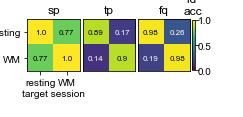

In [163]:

fig,axs = plt.subplots(1,3,figsize=(3,2))
colors=['b','orange','g']
titles=['sp','tp','fq']

for kk in range(3):
    data_to_plot= accs[kk,0,:].mean(axis=(-2,-1)).reshape([int(np.sqrt(accs.shape[2])),-1])
    im=axs[kk].imshow(data_to_plot, vmin=0,vmax=1)
    if kk==0:
        axs[kk].set_xticks(np.arange(int(np.sqrt(accs.shape[2]))))
        axs[kk].set_xticklabels(['resting', 'WM'])
        axs[kk].set_yticks(np.arange(int(np.sqrt(accs.shape[2]))))
        axs[kk].set_yticklabels(['resting', 'WM'])
        axs[kk].set_ylabel('target session',labelpad=2)#changed!!!!!
        axs[kk].set_xlabel('source session',labelpad=-1)
    else:
        axs[kk].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            left=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off
        axs[kk].tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    left=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off 
    axs[kk].tick_params(axis='both', which='major', pad=3)
    axs[kk].set_title(titles[kk])
    for i in range(int(np.sqrt(accs.shape[2]))):
        for j in range(int(np.sqrt(accs.shape[2]))):
            if data_to_plot[i, j]<=1/int(np.sqrt(accs.shape[2])):
                text = axs[kk].text(j, i, '{:.2}'.format(data_to_plot[i, j]) ,
                               ha="center", va="center", color="w",size=8)
            else:
                text = axs[kk].text(j, i, '{:.2}'.format(data_to_plot[i, j]) ,
               ha="center", va="center", color="k",size=8)

fig.subplots_adjust(wspace=0.05, hspace=0.35)
                
                

cbar = fig.colorbar(im,ax=axs,fraction=0.015, pad=0.01)
cbar.ax.set_title('id \nacc')
cbar.ax.tick_params(axis='both', which='major', pad=-0.5)


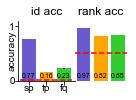

In [168]:
fig,axs = plt.subplots(1,2,figsize=(2,1.1))
colors=['slateblue','orange','limegreen']
titles=['id acc','rank acc']
acc_combined = [np.take(accs, [i for i in range(accs.shape[2]) if np.mod(i,int(np.sqrt(accs.shape[2]))+1)!=0], axis=2)
,np.take(accs_rank, [i for i in range(accs_rank.shape[2]) if np.mod(i,int(np.sqrt(accs_rank.shape[2]))+1)!=0], axis=2)
]


for kk in range(2):
    data_to_plot= acc_combined[kk][:,0]
    axs[kk].bar(np.arange(len(acc_combined[0])), data_to_plot.mean(axis=(-3,-2,-1)),yerr=[ss.sem(data_to_plot[i].reshape(-1)) for i in range(3)], capsize=0,color=colors)
    if kk==0:
        axs[kk].hlines(y=1/77, xmin=0-0.5, xmax=len(acc_combined[0])-1+0.5, linestyles='dashed', linewidth=1.5, label='random baseline', color='r')
        axs[kk].set_ylabel('accuracy',labelpad=-7)
    else: 
        axs[kk].hlines(y=(77+1)/(2*77), xmin=0-0.5, xmax=len(acc_combined[0])-1+0.5, linestyles='dashed', linewidth=1.5, label='random baseline', color='r')

    axs[kk].set_ylim([0,1.1])
    axs[kk].spines['right'].set_visible(False)
    axs[kk].spines['top'].set_visible(False)
    
    if kk>0:
        axs[kk].spines['bottom'].set_visible(False)
        axs[kk].spines['left'].set_visible(False)       
        axs[kk].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
        axs[kk].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off

    if kk==0:
        axs[kk].set_xticks(np.arange(3))
        axs[kk].set_xticklabels(['sp','tp','fq'])
    for jj in range(3):
        axs[kk].text(-0.4+jj, 0.05, '{:.2}'.format(data_to_plot.mean(axis=(-3,-2,-1))[jj]),size=7)
    axs[kk].tick_params(axis='both', which='major', pad=-0.5)
    axs[kk].set_title(titles[kk])

    
fig.subplots_adjust(wspace=-0.05)


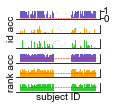

In [4]:
fig,axs = plt.subplots(6,1,figsize=(1.5,1.5))

colors=['slateblue','orange','limegreen']
titles=['sp','tp','fq']
acc_combined = [np.take(accs, [i for i in range(accs.shape[2]) if np.mod(i,int(np.sqrt(accs.shape[2]))+1)!=0], axis=2)
,np.take(accs_rank, [i for i in range(accs_rank.shape[2]) if np.mod(i,int(np.sqrt(accs_rank.shape[2]))+1)!=0], axis=2)
]
random_baselines = [1/77,(77+1)/(2*77)]

cnt = 0
for aid in range(2):
    for kk in range(3):
        data_to_plot= acc_combined[aid][kk,0]
        axs[cnt].bar(np.arange(acc_combined[aid][kk,0].shape[-1]), data_to_plot.mean(axis=(0,1)),yerr=[ss.sem(data_to_plot[:,:,i].reshape(-1)) for i in range(data_to_plot.shape[-1])],error_kw=dict(lw=0.25, capsize=0),color=colors[kk])
        axs[cnt].hlines(y=random_baselines[aid], xmin=0-0.5, xmax=acc_combined[aid][kk,0].shape[-1]-1+0.5, linestyles='dashed', linewidth=0.5, label='random baseline', color='r')
        axs[cnt].set_ylim([-0.05,1.05])
        axs[cnt].spines['left'].set_visible(False)
        axs[cnt].spines['top'].set_visible(False)
        axs[cnt].yaxis.tick_right()
        axs[cnt].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
        if cnt>0:
            axs[cnt].tick_params(
                    axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    right=False,      # ticks along the bottom edge are off
                    bottom=False,          # ticks along the top edge are off
                    labelright=False) # labels along the bottom edge are off

        if cnt==1:
            axs[cnt].set_ylabel('id acc',labelpad=0)
        if cnt==4:
            axs[cnt].set_ylabel('rank acc',labelpad=0)
            
        if cnt==5:
            axs[cnt].set_xticks(np.arange(acc_combined[aid][kk,0].shape[-1]))
            axs[cnt].set_xticklabels(np.arange(acc_combined[aid][kk,0].shape[-1])+1)
            axs[cnt].set_xlabel('subject ID',labelpad=1)
        axs[cnt].tick_params(axis='both', which='major', pad=-0.1)
        cnt=cnt+1
    
fig.subplots_adjust(hspace=0.7)

# MEG-EEG (Figure 6)

In [14]:
savename='meg-eeg-features'
data = sio.loadmat(savename)
eeg_tp=data['eeg_tp']
eeg_fq=data['eeg_fq']
meg_tp=data['meg_tp']
meg_fq=data['meg_fq']

feature_tp = np.row_stack((meg_tp,eeg_tp))
feature_fq = np.row_stack((meg_fq,eeg_fq))
features = [feature_tp,feature_fq]

accs=[get_acc_results(features[i], n_train_rep,False, False)[0] for i in range(2)]  
accs=np.array(accs)

accs_rank=[get_acc_results(features[i], n_train_rep,False,True)[0] for i in range(2)]  
accs_rank=np.array(accs_rank)

In [22]:
data_to_plot = np.zeros([2,2,2]) #feature, first row, second row
for i in range(2):
    cnt = 0
    for j,k in [[0,1],[1,0]]:
        data_to_plot[i,j,k] = np.mean(accs[i][0,cnt+1])
        cnt+=1

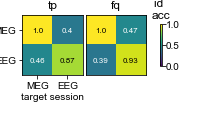

In [24]:
fig,axs = plt.subplots(1,2,figsize=(2.5,2))
colors=['orange','g']
titles=['tp','fq']

for kk in range(2):
    im=axs[kk].imshow(data_to_plot[kk], vmin=0,vmax=1)
    if kk==0:
        axs[kk].set_xticks(np.arange(2))
        axs[kk].set_xticklabels(['MEG', 'EEG'])
        axs[kk].set_yticks(np.arange(2))
        axs[kk].set_yticklabels(['MEG', 'EEG'])
        axs[kk].set_xlabel('target session',labelpad=2)
        axs[kk].set_ylabel('source session',labelpad=-1)
    else:
        axs[kk].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            left=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off
        axs[kk].tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    left=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off 
    axs[kk].tick_params(axis='both', which='major', pad=3)
    axs[kk].set_title(titles[kk])
    for i in range(2):
        for j in range(2):
            if data_to_plot[kk][i, j]<=1/2:
                text = axs[kk].text(j, i, '{:.2}'.format(data_to_plot[kk][i, j]) ,
                               ha="center", va="center", color="w",size=8)
            else:
                text = axs[kk].text(j, i, '{:.2}'.format(data_to_plot[kk][i, j]) ,
               ha="center", va="center", color="k",size=8)

fig.subplots_adjust(wspace=0.05, hspace=0.35)
                
                

cbar = fig.colorbar(im,ax=axs,fraction=0.015, pad=.1)
cbar.ax.set_title('id \nacc')
cbar.ax.tick_params(axis='both', which='major', pad=.1)


In [32]:
acc_combined = [accs,accs_rank]
data_to_plot_means = np.zeros([2,2]) #acc_type, feature
data_to_plot_sem = np.zeros([2,2]) 

for i in range(2):
    for j in range(2):
        data_to_plot_means[i,j] = np.mean([acc_combined[i][j][0,1],acc_combined[i][j][0,2]])
        data_to_plot_sem[i,j] = ss.sem(np.array([acc_combined[i][j][0,1],acc_combined[i][j][0,2]]).reshape(-1))


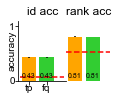

In [36]:
fig,axs = plt.subplots(1,2,figsize=(1.7,1.1))
colors=['orange','limegreen']
titles=['id acc','rank acc']


for kk in range(2):
    data_to_plot= acc_combined[kk][:,0]
    axs[kk].bar(np.arange(2), data_to_plot_means[kk],yerr=data_to_plot_sem[kk], capsize=0,color=colors)
    if kk==0:
        axs[kk].hlines(y=1/15, xmin=0-0.5, xmax=2, linestyles='dashed', linewidth=1.5, label='random baseline', color='r')
        axs[kk].set_ylabel('accuracy',labelpad=-7)
    else: 
        axs[kk].hlines(y=(15+1)/(2*15), xmin=0-0.5, xmax=2, linestyles='dashed', linewidth=1.5, label='random baseline', color='r')

    axs[kk].set_ylim([0,1.1])
    axs[kk].spines['right'].set_visible(False)
    axs[kk].spines['top'].set_visible(False)
    
    if kk>0:
        axs[kk].spines['bottom'].set_visible(False)
        axs[kk].spines['left'].set_visible(False)       
        axs[kk].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
        axs[kk].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off

    if kk==0:
        axs[kk].set_xticks(np.arange(2))
        axs[kk].set_xticklabels(['tp','fq'])
    for jj in range(2):
        axs[kk].text(-0.4+jj, 0.05, '{:.2}'.format(data_to_plot_means[kk,jj]),size=7)
    axs[kk].tick_params(axis='both', which='major', pad=-0.5)
    axs[kk].set_title(titles[kk])
    
fig.subplots_adjust(wspace=-0.05)

In [38]:
acc_combined = [accs,accs_rank]
data_to_plot_means = np.zeros([2,2,15]) #acc_type, feature,individual
data_to_plot_sem = np.zeros([2,2,15]) 

for i in range(2):
    for j in range(2):
        data_to_plot_means[i,j] = np.array([acc_combined[i][j][0,1],acc_combined[i][j][0,2]]).mean(axis=(0,1))
        data_to_plot_sem[i,j] = ss.sem(np.array([acc_combined[i][j][0,1],acc_combined[i][j][0,2]]).reshape([-1,15]))


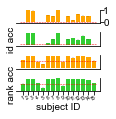

In [41]:
fig,axs = plt.subplots(4,1,figsize=(1.5,1.5))
colors=['orange','limegreen']
titles=['tp','fq']
random_baselines = [1/15,(15+1)/(2*15)]

cnt = 0
for aid in range(2):
    for kk in range(2):

        axs[cnt].bar(np.arange(15),data_to_plot_means[aid][kk],yerr=data_to_plot_sem[aid][kk],error_kw=dict(lw=0.25, capsize=0),color=colors[kk])
        axs[cnt].hlines(y=random_baselines[aid], xmin=0-0.5, xmax=15-1+0.5, linestyles='dashed', linewidth=0.5, label='random baseline', color='r')
        axs[cnt].set_ylim([-0.05,1.05])
        axs[cnt].spines['left'].set_visible(False)
        axs[cnt].spines['top'].set_visible(False)
        axs[cnt].yaxis.tick_right()
        if cnt < 3:
            axs[cnt].tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
        if cnt>0:
            axs[cnt].tick_params(
                    axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    right=False,      # ticks along the bottom edge are off
                    bottom=False,          # ticks along the top edge are off
                    labelright=False) # labels along the bottom edge are off

        if cnt==1:
            axs[cnt].set_ylabel('id acc',labelpad=0)
        if cnt==3:
            axs[cnt].set_ylabel('rank acc',labelpad=0)
            
        if cnt==3:
            axs[cnt].set_xticks(np.arange(15))
            axs[cnt].set_xticklabels(np.arange(15)+1,fontsize = 5,rotation = 30 )
            axs[cnt].set_xlabel('subject ID',labelpad=1)
        axs[cnt].tick_params(axis='both', which='major', pad=-0.1)
        cnt=cnt+1
    
fig.subplots_adjust(hspace=0.7)


# Feature importance (Figure 7)

In [ ]:
n_train_rep=100
features1=[]
features2=[]
features3=[]
root_dir = "root_dir";
subj_names = ['AT','DR','JG','JK']

#[nsessions nsubjects ntrainsizes nrep_per_trainsize]
for session in [1,2,3,4]:
    tmp1 = []
    tmp2 = []
    tmp3 = []

    for subj in subj_names:
        names = glob.glob(root_dir+subj+'/session'+str(session)+'/fst_b*.fif')
        fname=names[-1]     
        data = sio.loadmat(fname[:-6]+'feature_sst_empty_filter_ecg_eog.mat')
        feature1 = data['feature1']
        feature2 = data['feature2']
        feature3 = data['feature3']
        tmp1.append(feature1)
        tmp2.append(feature2)
        tmp3.append(feature3)

    features1.append(tmp1)
    features2.append(tmp2)
    features3.append(tmp3)

feature1=np.array(features1)
feature2=np.array(features2)
feature3=np.array(features3)

feature1=feature1[:,:,-n_train_rep:]
feature2=feature2[:,:,-n_train_rep:]
feature3=feature3[:,:,-n_train_rep:]


In [ ]:

fs = np.array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100.])
fs =fs[:-1]

subfeature3 = [feature3[:,:,:,0:3],feature3[:,:,:,3:5],feature3[:,:,:,5:8],feature3[:,:,:,8:17],feature3[:,:,:,17:]]

accs3=np.array([get_acc_results(subfeature3[i], 100,True)[0] for i in range(len(subfeature3))]) 
accs3=np.take(accs3, [i for i in range(accs3.shape[2]) if np.mod(i,int(np.sqrt(accs3.shape[2]))+1)!=0], axis=2)
accs3=np.squeeze(accs3)
accs3.shape


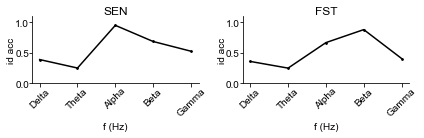

In [49]:
fig, axs = plt.subplots(1,2,figsize=(6,1.5))
fig.tight_layout()
titles=['SEN','FST']
accs = [sen_freq,fst_freq]
for kk in range(2):
    axs[kk].scatter(np.arange(5), accs[kk].mean(axis=(1,2,3)),c='k',s=3)
    axs[kk].errorbar(np.arange(5), accs[kk].mean(axis=(1,2,3)), yerr=[ss.sem(accs[kk][i].reshape(-1)) for i in range(accs[kk].shape[0])], capsize=0,capthick=1.5,linewidth=1.5,elinewidth=0.5,c='k')
    axs[kk].spines['right'].set_visible(False)
    axs[kk].spines['top'].set_visible(False)
    axs[kk].set_ylabel('id acc',labelpad=-1)
    
    if kk==10:
        axs[kk].spines['bottom'].set_visible(False)
        axs[kk].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            left=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
        axs[kk].set_xlabel('f (Hz)')
    axs[kk].tick_params(axis='both', which='major', pad=-0.5)

    axs[kk].set_title(titles[kk],pad=0)
    axs[kk].set_xticks(np.arange(5))
    axs[kk].set_xticklabels(['Delta','Theta','Alpha','Beta','Gamma'],rotation=45)
    axs[kk].set_ylim([0,1.1])
        
fig.subplots_adjust(hspace=0.15)


In [ ]:
LT=np.array([1,7,10,13,16,163,22,19,172,166,175,178,169])
RT=np.array([154,139,142,160,157,148,145,295,298,271,274,304,301])
LP=np.array([37,40,67,46,43,73,199,202,82,181,208,205,223])
RP=np.array([112,115,118,76,124,121,79,247,250,256,253,226,280])
LF=np.array([52,49,55,88,25,58,61,4,34,28,31,70,64])
RF=np.array([85,91,94,100,103,106,97,127,109,136,133,130,151])
LO=np.array([184,190,211,220,232,187,193,214,235,196,217,244])
RO=np.array([229,259,277,262,286,268,283,289,238,265,292,241])
sensor_groups = list([LT,RT,LP,RP,LF,RF,LO,RO])

subfeature1 = []
for i in range(len(sensor_groups)):
    for j in range(len(sensor_groups)):
        inds1 = ((sensor_groups[i]-1)/3).astype('int')
        inds2 = ((sensor_groups[j]-1)/3).astype('int')
        tmp = feature1[:,:,:,inds1,:]
        tmp=tmp[:,:,:,:,inds2]
        subfeature1.append(tmp)


accs1=np.array([get_acc_results(subfeature1[i], 100,True) for i in range(len(subfeature1))]) 
accs1=np.take(accs1, [i for i in range(accs1.shape[2]) if np.mod(i,int(np.sqrt(accs1.shape[2]))+1)!=0], axis=2)
accs1=np.squeeze(accs1)
accs1.shape

time_groups = [np.arange(i*10,i*10+1*10) for i in range(10)]
subfeature2 = []
for i in range(len(time_groups)):
    for j in range(len(time_groups)):
        inds1 = time_groups[i].astype('int')
        inds2 = time_groups[j].astype('int')
        tmp = feature2[:,:,:,inds1,:]
        tmp=tmp[:,:,:,:,inds2]
        subfeature2.append(tmp)




accs2=np.array([get_acc_results(subfeature2[i], 100,True) for i in range(len(subfeature2))]) 
accs2=np.take(accs2, [i for i in range(accs2.shape[2]) if np.mod(i,int(np.sqrt(accs2.shape[2]))+1)!=0], axis=2)
accs2=np.squeeze(accs2)
accs2.shape

fs = np.array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100.])
fs =fs[:-1]

subfeature3 = [feature3[:,:,:,i:i+5] for i in range(feature3.shape[-1]-5)]


accs3=np.array([get_acc_results(subfeature3[i], 100,True) for i in range(len(subfeature3))]) 
accs3=np.take(accs3, [i for i in range(accs3.shape[2]) if np.mod(i,int(np.sqrt(accs3.shape[2]))+1)!=0], axis=2)
accs3=np.squeeze(accs3)
accs3.shape


In [117]:
filepath='data_path'
data = sio.loadmat(filepath)
accs1=data['accs1']
accs2=data['accs2']
accs3=data['accs3']


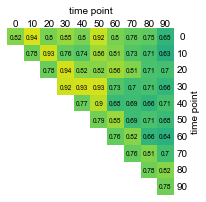

In [119]:
from matplotlib import cm as CM

fig, axs = plt.subplots(1,1,figsize=(3,3))
fig.tight_layout()

labels = np.arange(10)*10

cmap = CM.get_cmap('viridis')
cmap.set_bad('w') 


data_to_plot=accs2.mean(axis=(1,2,3)).reshape(10,-1)
for jj in range(10):
    for kk in range(10):
        if jj>kk:
            data_to_plot[jj,kk]=0
data_to_plot=np.ma.array(data_to_plot,mask=data_to_plot==0)
         
im = axs.imshow(data_to_plot,vmin=0,vmax=1,cmap=cmap)
for i in range(10):
    for j in range(10):
        if i<=j:
            text = axs.text(j, i, '{:.2}'.format(data_to_plot[i, j]) ,
                               ha="center", va="center", color="k",size=6.5)
axs.spines['bottom'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            left=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off
axs.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            left=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off   


text = cbaxes.text(-1.1, 0.5, 'id acc' ,
                               ha="center", va="center", color="k",rotation=90)

axs.set_xlabel('time point',labelpad=15)
axs.xaxis.set_label_position('top') 

axs.set_ylabel('time point',labelpad=17)
axs.yaxis.set_label_position('right') 

for i in range(10):
    text = axs.text(i, -0.8, labels[i],
                       ha="center", va="center", color="k")
    text = axs.text(10, i, labels[i],
                           ha="center", va="center", color="k")
            

# Trainsize and preprocessing (Figure 8)

In [ ]:
filepath='datapath'
data = sio.loadmat(filepath)
accs = data['accs']
print(accs.shape)
data_to_plot_fst=np.take(accs, [i for i in range(accs.shape[2]) if np.mod(i,int(np.sqrt(accs.shape[2]))+1)!=0], axis=2)

filepath='datapath'
data = sio.loadmat(filepath)
accs = data['accs']
print(accs.shape)
data_to_plot_sen=np.take(accs, [i for i in range(accs.shape[2]) if np.mod(i,int(np.sqrt(accs.shape[2]))+1)!=0], axis=2)

filepath='datapath'
data = sio.loadmat(filepath)
accs = data['accs']
print(accs.shape)
data_to_plot_hcp=np.take(accs, [i for i in range(accs.shape[2]) if np.mod(i,int(np.sqrt(accs.shape[2]))+1)!=0], axis=2)

data_to_plot=[data_to_plot_fst,data_to_plot_sen,data_to_plot_hcp]

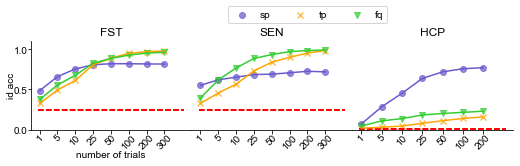

In [117]:

titles=['FST','SEN','HCP']
feat_names=['sp','tp','fq']

fig, axs = plt.subplots(1,3,figsize=(7.5,1.8))
fig.tight_layout()
colors=['slateblue','orange','limegreen']
markers=['o', 'x',  'v']
random_baseline = [1/4,1/4,1/77]
for dt in range(3):
    for kk in range(3):
        axs[dt].scatter(np.arange(data_to_plot[dt].shape[1]), data_to_plot[dt][kk].mean(axis=(1,2,3)),marker=markers[kk],color=colors[kk],alpha=0.7, label=feat_names[kk])
        axs[dt].errorbar(np.arange(data_to_plot[dt].shape[1]), data_to_plot[dt][kk].mean(axis=(1,2,3)), yerr=[ss.sem(data_to_plot[dt][kk].reshape([data_to_plot[dt][kk].shape[0],-1])[i]) for i in range(data_to_plot[dt][kk].shape[0])], capsize=0,capthick=1.5,linewidth=1.5,elinewidth=0.5,color=colors[kk])
        axs[dt].hlines(y=random_baseline[dt], xmin=0-0.1, xmax=data_to_plot[dt][kk].shape[0]+0.1, linestyles='dashed', linewidth=1.5, color='r')
        axs[dt].set_ylim([0,1.1])

    axs[dt].spines['right'].set_visible(False)
    axs[dt].spines['top'].set_visible(False)
    if dt>0:
        axs[dt].spines['left'].set_visible(False)
        axs[dt].tick_params(axis='y',which='both',left=False,labelleft=False)
    else:
        axs[dt].set_ylabel('id acc',labelpad=-2.5)
        axs[dt].set_xlabel('number of trials',labelpad=-1)
    if dt <2:
        axs[dt].set_xticks(np.arange(len([1,5,10,25,50,100,200,300])))
        axs[dt].set_xticklabels([1,5,10,25,50,100,200,300],rotation=45)
    else:
        axs[dt].set_xticks(np.arange(len([1,5,10,25,50,100,200])))
        axs[dt].set_xticklabels([1,5,10,25,50,100,200],rotation=45)
        
    axs[dt].tick_params(axis='both', which='major', pad=-0.5)

    axs[dt].set_title(titles[dt])

fig.subplots_adjust(wspace=0)
axs[0].legend( bbox_to_anchor=(2.25, 1.45),ncol=3,labelspacing=3,frameon=True)    


In [ ]:
filepath='datapath'
data = sio.loadmat(filepath)
accs = data['accs']
data_to_plot_fst_full=np.take(accs, [i for i in range(accs.shape[2]) if np.mod(i,int(np.sqrt(accs.shape[2]))+1)!=0], axis=2)
data_to_plot_fst_full=data_to_plot_fst_full[:,-1]
data_to_plot_fst_full=data_to_plot_fst_full.mean(axis = iii)
data_to_plot_fst_full=data_to_plot_fst_full.reshape(3,-1)
print(data_to_plot_fst_full.shape)


filepath='datapath'
data = sio.loadmat(filepath)
accs = data['accs']
data_to_plot_fst_raw=np.take(accs, [i for i in range(accs.shape[2]) if np.mod(i,int(np.sqrt(accs.shape[2]))+1)!=0], axis=2)
data_to_plot_fst_raw=data_to_plot_fst_raw[:,-1]
data_to_plot_fst_raw=data_to_plot_fst_raw.mean(axis = iii)
data_to_plot_fst_raw=data_to_plot_fst_raw.reshape(3,-1)
print(data_to_plot_fst_raw.shape)

data_to_plot = [data_to_plot_fst_raw,data_to_plot_fst_full,data_to_plot_sen_raw,data_to_plot_sen_full]


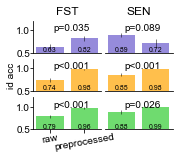

In [138]:

fig,axs = plt.subplots(3,2,figsize=(2.5,2*1))

colors=['slateblue','orange','limegreen']
titles=['FST','SEN']
feat_names=['sp','tp','fq']

for kk in range(2):
    for jj in range(3):
        
        draw = data_to_plot[kk*2][jj]
        dfull = data_to_plot[kk*2+1][jj]
        
        y_mean = [draw.mean(),dfull.mean()]
        y_std = [draw.std(),dfull.std()]
        y_SE = [ss.sem(draw),ss.sem(dfull)]

        [nothing,p_val]=ss.ttest_ind(draw,dfull)
        if p_val<0.001:
            p_string = 'p<0.001'
        else:
            p_string = 'p={:.2}'.format(p_val)
        
        axs[jj,kk].bar([0,1], y_mean,yerr=y_SE,error_kw=dict(lw=0.5, capsize=0),color=colors[jj],label=feat_names[jj], alpha = 0.7)
        
        axs[jj,kk].set_ylim([0.5,1.2])
        axs[jj,kk].spines['right'].set_visible(False)
        axs[jj,kk].spines['top'].set_visible(False)
        
        if kk==1:
            axs[jj,kk].spines['left'].set_visible(False)
            axs[jj,kk].tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                left=False,         # ticks along the top edge are off
                labelleft=False) # labels along the bottom edge are off
            axs[jj,kk].tick_params(axis='x',which='both', bottom=False,top=False,labelbottom=False)
            
        if (kk==0) and (jj==1):
            axs[jj,kk].set_ylabel('id acc',labelpad=0)
        if (jj==2) and (kk==0):
            axs[jj,kk].set_xticks([0,1])
            axs[jj,kk].set_xticklabels(['raw','preprocessed'],rotation=10)
        if jj<2:
            axs[jj,kk].tick_params(axis='x',which='both', bottom=False,top=False,labelbottom=False)
        if (jj==0):
            axs[jj,kk].set_title(titles[kk])
            
        axs[jj,kk].tick_params(axis='both', which='major', pad=-0.5)

        axs[jj,kk].text(0.1,0.99,p_string)
        for mm in range(2):
            axs[jj,kk].text(-0.2+mm,0.53,'{:.2}'.format(y_mean[mm]),size=7)

        
fig.subplots_adjust(wspace=0.05)
